# Agostino Aiezzo - number: 0000982514
## email: agostino.aiezzo@studio.unibo.it

## The basic idea to solve this problem is to do something similar to Lab6: find the object (in this case the cover of the book) in each frame of the video and then project the augmented layer in an identified zone. So, object detection is the key.

In [1]:
'''Libraries needed'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Firstly, modify the augmented layer in order to fit it better on the cover of the book.

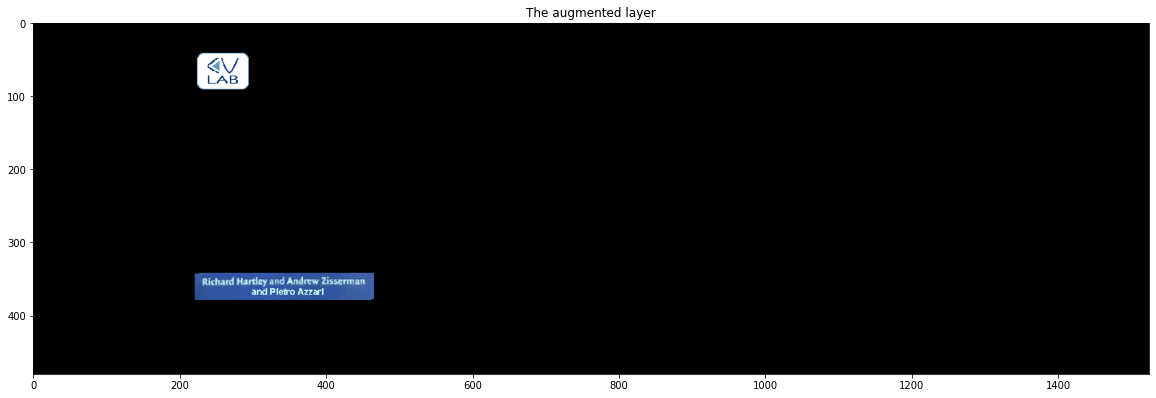

In [2]:
'''Load the augmented layer'''
al = cv2.imread('AugmentedLayer.PNG') 
al_copy = al.copy() # Operate on a copy just to be safe
plt.figure(figsize=(20,10))
plt.title('The augmented layer')
plt.imshow(cv2.cvtColor(al_copy, cv2.COLOR_BGR2RGB))
plt.show()

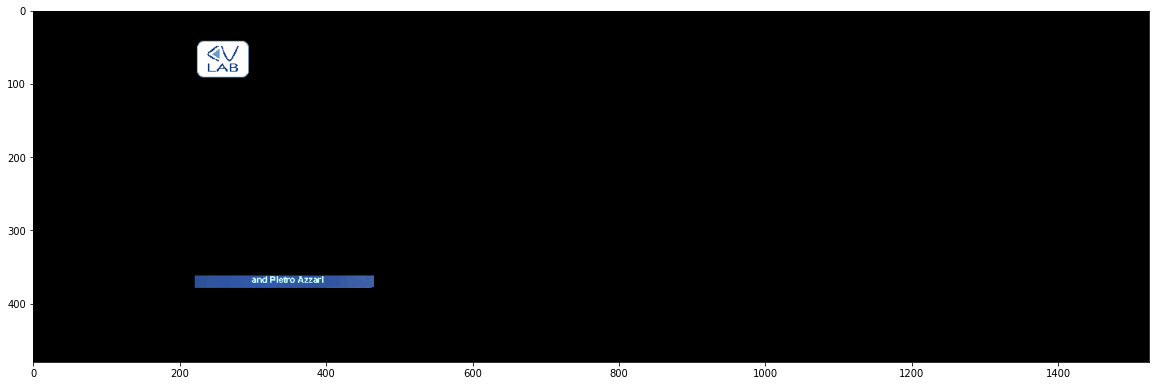

In [3]:
'''Remove the redundant names'''
al_copy[340:362, 215:470] = 0 
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(al_copy, cv2.COLOR_BGR2RGB))
plt.show()

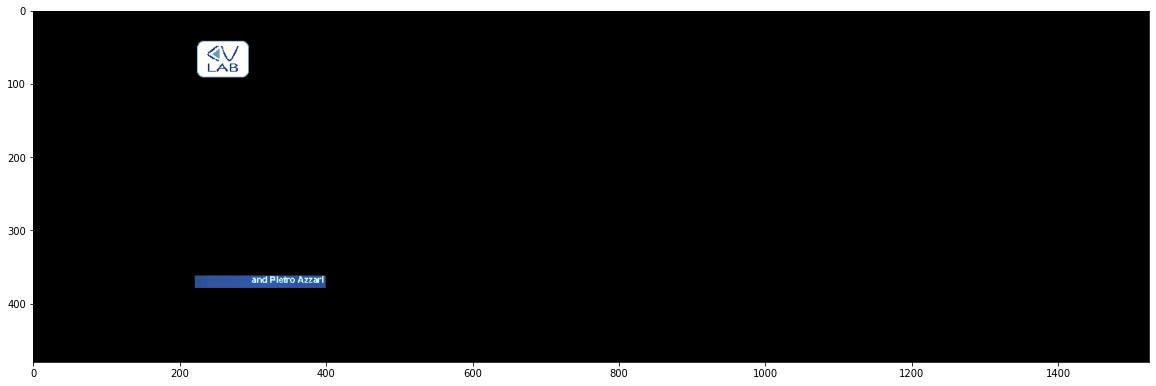

In [4]:
'''Redefine the edge (the right one) by obscuring specific pixels'''
al_copy[361:383, 400:470] = 0 
plt.figure(figsize=(20,10)) 
plt.imshow(cv2.cvtColor(al_copy, cv2.COLOR_BGR2RGB))
plt.show()

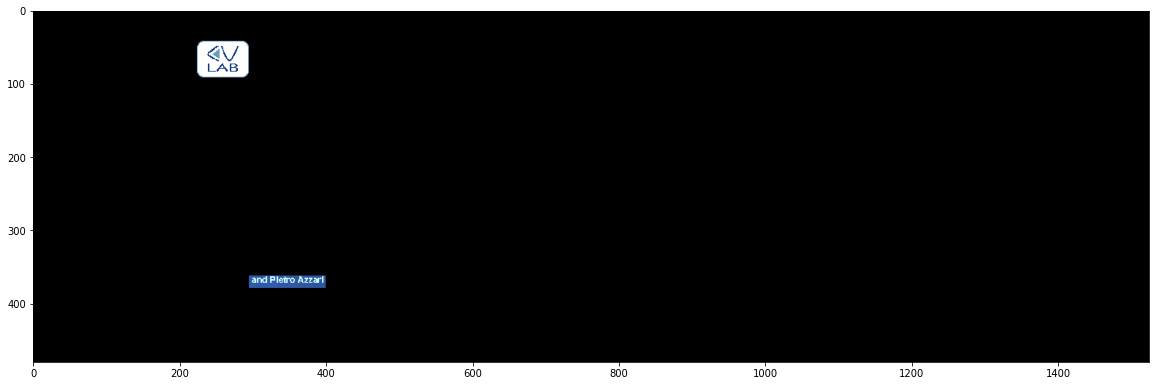

In [5]:
'''Redefine the edge (the left one) by obscuring specific pixels'''
al_copy[361:383, 200:295] = 0 
plt.figure(figsize=(20,10))
plt.imshow(cv2.cvtColor(al_copy, cv2.COLOR_BGR2RGB))
plt.show()

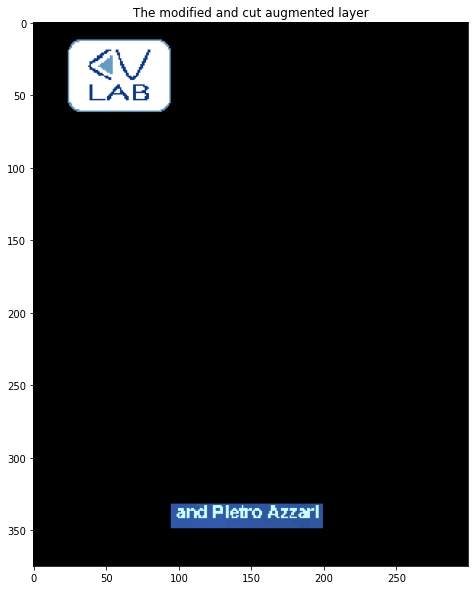

In [6]:
'''This is the final image which will be projected on the book'''
roi = al_copy[30:405,200:500] # Region of interest. 
plt.figure(figsize=(20,10))
plt.title('The modified and cut augmented layer')
plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
plt.show()

## Secondly, search the cover and apply the additive layer.

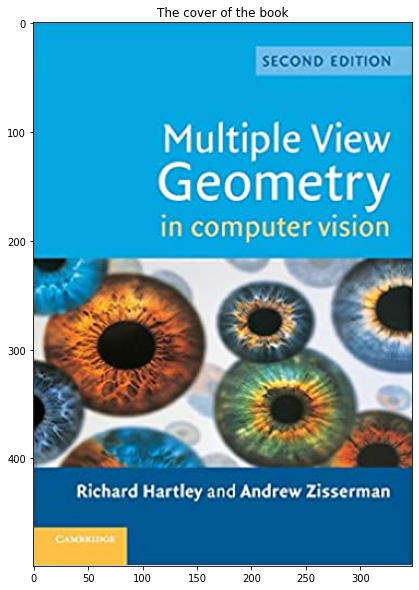

In [7]:
MIN_MATCH_COUNT=50 #This will be useful later

'''Load the video and the cover that need to be searched'''
cap = cv2.VideoCapture('Multiple View.avi')
query_img = cv2.imread('MVG_in_computer_vision.jpg') 

plt.figure(figsize=(20,10))
plt.title('The cover of the book')
plt.imshow(cv2.cvtColor(query_img, cv2.COLOR_BGR2RGB)) #Plot the cover of the book
plt.show()

In [8]:
'''Inizialization of the parameters for the video capture.'''
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) 
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)
fourcc = cv2.VideoWriter_fourcc(*'DIVX')
out = cv2.VideoWriter('Augmented Multiple View.avi', fourcc, fps, (width, height)) 

'''Try-except statement to manage exceptions'''
try:
        
    while(cap.isOpened()): # Until the capture is open
        
        ret, frame = cap.read()
        
        if not ret or frame is None: # If the reading has been unsuccessfull or the are no frame anymore..
            cap.release() # Release the Video if ret is false
            out.release() # as well as the video capture
            print("Released Video Resource")
            break # Exit from the loop
            
        sift = cv2.xfeatures2d.SIFT_create() # Initiating SIFT detector.
    
        ''' Computation of the key points and descriptors of the query image'''
        kp_query = sift.detect(query_img)
        kp_query, query_des = sift.compute(query_img, kp_query)
        
        ''' Computation of the key points and descriptors of the frame'''
        kp_frame = sift.detect(frame)
        kp_frame, frame_des = sift.compute(frame, kp_frame)
        
        '''Match descriptors using a Flann algorithm'''
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(ckecks=50)
        flann= cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(query_des, frame_des, k=2) 
        
        '''Filtering the good matches according to Lowe's ratio test'''
        good = []
        for m,n in matches:
            if m.distance < 0.7*n.distance:
                good.append(m)
        
        if len(good)>MIN_MATCH_COUNT: #Only in the case in which there are more than MIN_MATCH_COUNT correspondences, 
                                      #the program proceeds
            
            '''Building the correspondences arrays of good matches'''
            src_pts = np.float32([kp_query[m.queryIdx].pt for m in good]).reshape(-1,1,2)
            dst_pts = np.float32([kp_frame[m.trainIdx].pt for m in good]).reshape(-1,1,2)
            
            '''Getting the coordinates of the corners of the query object in the frame image.'''
            M, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0) # Using RANSAC to estimate a robust homography.
            h, w = query_img.shape[0], query_img.shape[1] 
            pts = np.float32([[0,0],[0,h-1],[w-1,h-1],[w-1,0]]).reshape(-1,1,2)
            rect = cv2.perspectiveTransform(pts,M)

            '''Getting the homography to project img_ar on the surface of the query object'''
            h1,w1 = frame.shape[0], frame.shape[1] 
            h2,w2 = roi.shape[0], roi.shape[1]
            dst = np.float32([[0,0],[0,h2-1],[w2-1,h2-1],[w2-1,0]]).reshape(-1,1,2)
            H = cv2.getPerspectiveTransform(dst, rect) 
            warped = cv2.warpPerspective(roi, H, (w1,h1))
            
            '''This first mask is used to restore the pixels outside the cover'''            
            white = np.ones([h2,w2], dtype=np.uint8)*255
            mask1 = cv2.warpPerspective(white, H, (w1,h1))
            mask1 = np.equal(mask1,0)
            warped[mask1] = frame[mask1]
            
            '''This second mask is used to restore the pixels inside the cover'''
            warped_copy = warped.copy() #Just to be safe
            mask2 = (warped == 0)*255
            mask2 = abs(mask2-255)
            mask2 = np.equal(mask2,0)
            warped_copy[mask2] = frame[mask2]
            
            '''Display the result'''
            plt.figure(figsize=(20,10))
            plt.imshow(cv2.cvtColor(warped_copy, cv2.COLOR_BGR2RGB))
            plt.show()
            
            out.write(warped_copy) # Write the result in the video.

            clear_output(wait=True) # Clear cell output when new frame is available
    
        else:
            print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
            
except KeyboardInterrupt:  # Press stop (jupyter GUI) to release the video
    cap.release()
    out.release()
    print("Released Video Resource")

Released Video Resource
